<a href="https://colab.research.google.com/github/AlekseiMikhalev/Data-Science-Projects/blob/master/ULMFiT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__ULMFiT tweets sentiment analysis__

In [0]:
#Importing Libraries 

from fastai.metrics import accuracy #explain why?
from fastai.text import * #explain why?
from fastai import * #explain why?
import gc #explain why?
import os #explain why?
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np #linear algebra
import matplotlib.pyplot as plt #library for visualization 

In [2]:
#Open the dataset and explore it
tweets = pd.read_csv('/content/Tweets.csv')
print('Shape: ', tweets.shape) #check the shape of the dataframe
tweets.head()

Shape:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
#Calculate the percentage of null values in each column and sort in descending order
print("The percentage of null or na values in the dataset")
((tweets.isnull() | tweets.isna()).sum() * 100 / tweets.index.size).round(2).sort_values(ascending=False)

The percentage of null or na values in the dataset


negativereason_gold             99.78
airline_sentiment_gold          99.73
tweet_coord                     93.04
negativereason                  37.31
user_timezone                   32.92
tweet_location                  32.33
negativereason_confidence       28.13
tweet_created                    0.00
text                             0.00
retweet_count                    0.00
name                             0.00
airline                          0.00
airline_sentiment_confidence     0.00
airline_sentiment                0.00
tweet_id                         0.00
dtype: float64

In [0]:
#Droping top 3 columns with the highest percentage of missing values
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

###__Data visualization__

*Visualize the total number of tweets per each airlines*

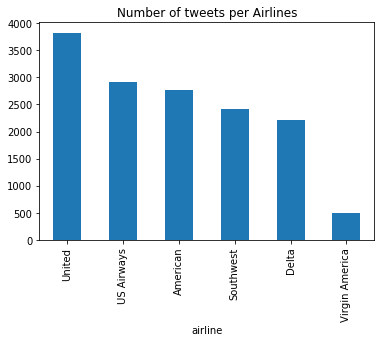

In [5]:
tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of tweets per Airlines')
plt.show()

*Tweet sentiments per each airlines*

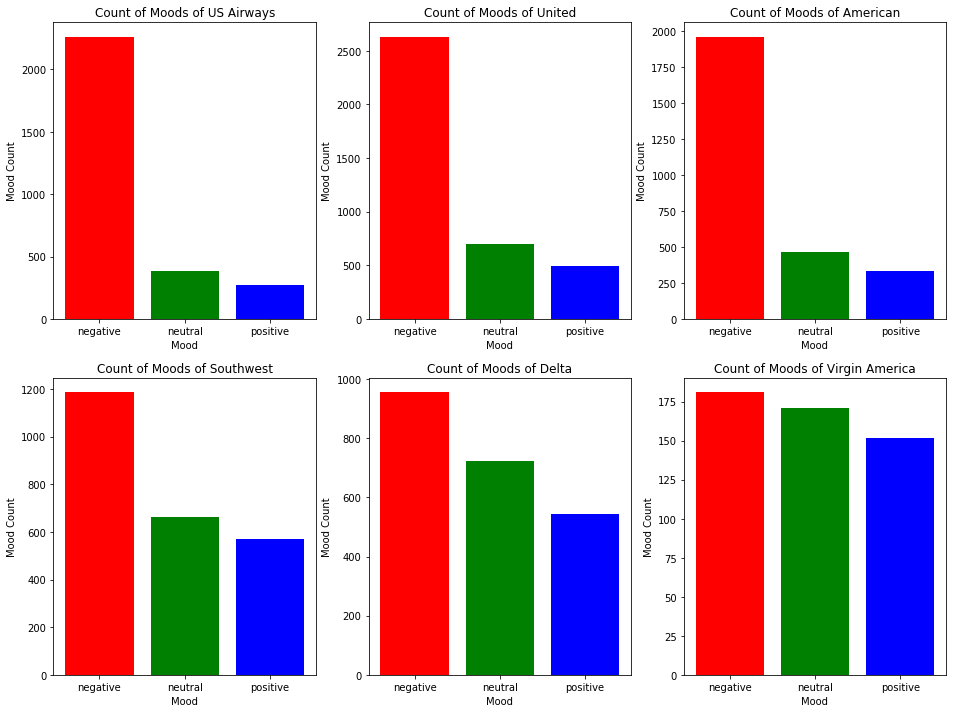

In [6]:
#Let's plot bar charts that show the number of tweets in each sentiment group per airlines
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

plt.figure(1,figsize=(16, 12))
for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2, 3, indices+1)
    new_df=tweets[tweets['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1, 2, 3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

###__Wordclouds__ of the __Positive__, __Negative__, __Neutral__ - airline_sentiment

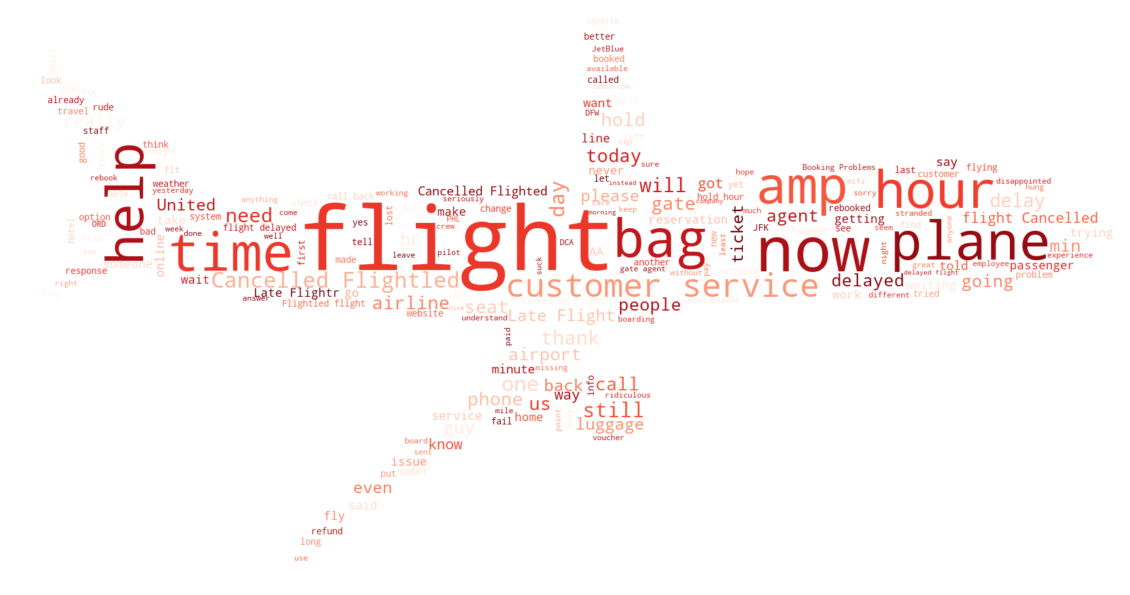

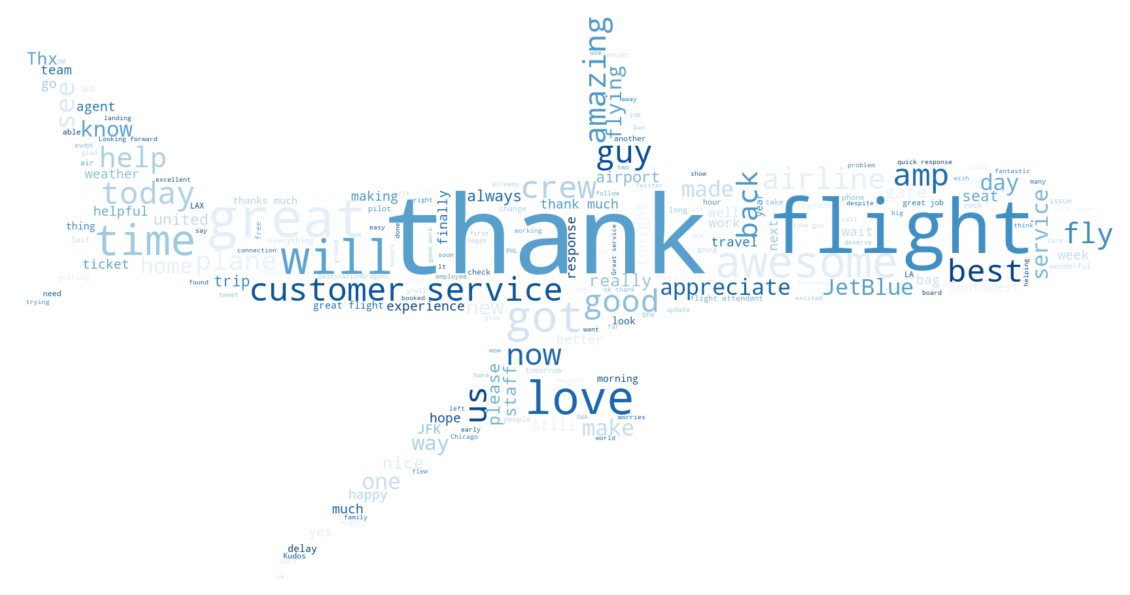

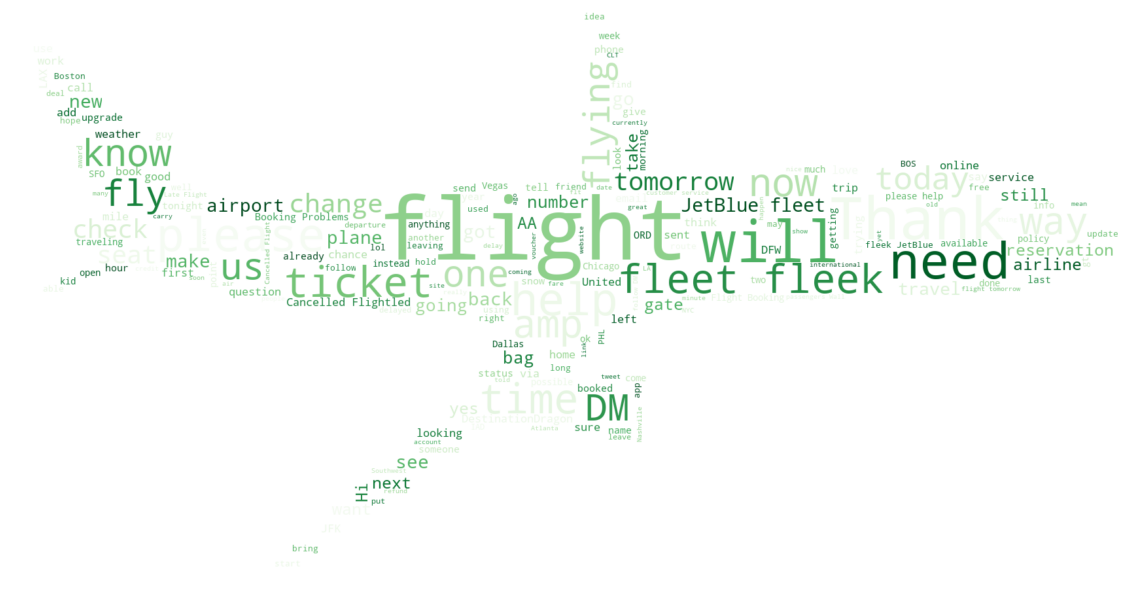

In [7]:
from wordcloud import WordCloud,STOPWORDS  #WordCloud is used for data visualization. The size of each word indicates its frequency or importance.
from PIL import Image # to import the image for the shape 
wave_mask = np.array(Image.open( "/content/airbus.jpg"))

#Positive sentiments
words_positive = ' '.join(tweets[tweets['airline_sentiment']=='positive']['text'])
cleaned_word_positive = " ".join([word for word in words_positive.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#Negative sentiments
words_negative = ' '.join(tweets[tweets['airline_sentiment']=='negative']['text'])
cleaned_word_negative = " ".join([word for word in words_negative.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#Neutral sentiments
words_neutral = ' '.join(tweets[tweets['airline_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud_negative = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Reds",  width=2048, height=2048).generate(cleaned_word_negative)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud_positive = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Blues", width=2048, height=2048).generate(cleaned_word_positive)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud_neutral = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Greens", width=2048, height=2048).generate(cleaned_word_neutral)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
negative_tokenized_tweets = []
positive_tokenized_tweets = []
neutral_tokenized_tweets = []
negative = cleaned_word_negative.split()
positive = cleaned_word_positive.split()
neutral = cleaned_word_neutral.split()
from nltk import flatten

for i in negative: 
  tokens = nltk.word_tokenize(i)
  negative_tokenized_tweets.append(tokens)
negative_tokenized_tweets = flatten(negative_tokenized_tweets)

for i in positive: 
  tokens = nltk.word_tokenize(i)
  positive_tokenized_tweets.append(tokens)
positive_tokenized_tweets = flatten(positive_tokenized_tweets)

for i in neutral: 
  tokens = nltk.word_tokenize(i)
  neutral_tokenized_tweets.append(tokens)
neutral_tokenized_tweets = flatten(neutral_tokenized_tweets)

print(negative_tokenized_tweets[0:9])
print(positive_tokenized_tweets[0:9])
print(neutral_tokenized_tweets[0:9])

['it', "'s", 'really', 'aggressive', 'to', 'blast', 'obnoxious', '``', 'entertainment']
['plus', 'you', "'ve", 'added', 'commercials', 'to', 'the', 'experience', '...']
['What', 'said', '.', 'I', 'did', "n't", 'today', '...', 'Must']


In [10]:
#Remove stopwords and punctuation from the lists of tweets
import string
negative_without_stopwords = []
positive_without_stopwords = []
neutral_without_stopwords = []

for w in negative_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    negative_without_stopwords.append(w)

for w in positive_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    positive_without_stopwords.append(w)

for w in neutral_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    neutral_without_stopwords.append(w)

print('Negative \n', negative_without_stopwords[0:9],'\n Positive \n', positive_without_stopwords[0:9],'\n Neutral \n', neutral_without_stopwords[0:9])

Negative 
 ["'s", 'really', 'aggressive', 'blast', 'obnoxious', '``', 'entertainment', "''", 'guests'] 
 Positive 
 ['plus', "'ve", 'added', 'commercials', 'experience', '...', 'tacky', 'yes', 'nearly'] 
 Neutral 
 ['What', 'said', 'I', "n't", 'today', '...', 'Must', 'mean', 'I']


In [11]:
from collections import Counter 
freq_negative = Counter(negative_without_stopwords)
freq_positive = Counter(positive_without_stopwords)
freq_neutral = Counter(neutral_without_stopwords)

#Create dataframes in pandas with two columns and sort it by frequency
freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())

Negative 
   words_negative  count
0              I   4318
1         flight   2336
2            n't   1759
3            get    949
4      Cancelled    920 
 Positive 
   words_positive  count
0              I    713
1         flight    326
2         thanks    320
3         Thanks    283
4          Thank    231 
 Neutral 
   words_neutral  count
0             I   1315
1        flight    495
2            's    359
3           get    235
4           n't    199


In [12]:
#It seems like we have many of "I" in the data sets, however it doesn't have any values, so we get rid of it too
stopword = "I"
for w in negative_without_stopwords:
  if w in stopword:
    negative_without_stopwords.remove(w)

for w in positive_without_stopwords:
  if w in stopword:
    positive_without_stopwords.remove(w)

for w in neutral_without_stopwords:
  if w in stopword:
    neutral_without_stopwords.remove(w)

#Create counter again
freq_negative = Counter(negative_without_stopwords)
freq_positive = Counter(positive_without_stopwords)
freq_neutral = Counter(neutral_without_stopwords)

#Create dataframes again
freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())

Negative 
   words_negative  count
0         flight   2336
1            n't   1759
2            get    949
3      Cancelled    920
4             's    903 
 Positive 
   words_positive  count
0         flight    326
1         thanks    320
2         Thanks    283
3          Thank    231
4          thank    204 
 Neutral 
   words_neutral  count
0        flight    495
1            's    359
2           get    235
3           n't    199
4           ...    182


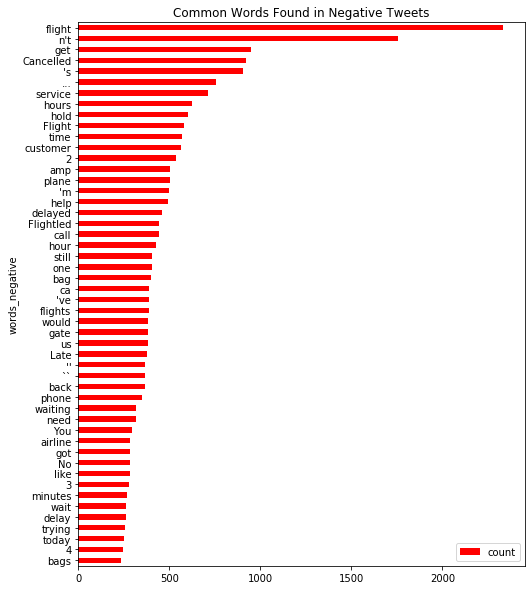

In [13]:
#Let's plot the results to check it visually
fig, ax = plt.subplots(figsize=(8, 10))

#Plot horizontal bar graph
#For negative words
freq_negative.sort_values(by='count').plot.barh(x='words_negative', y='count', ax=ax, color="red")
ax.set_title("Common Words Found in Negative Tweets")
plt.show()

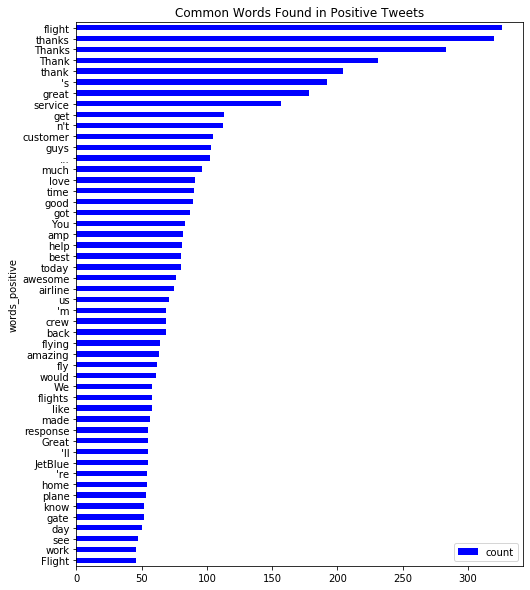

In [14]:
#For positive words
fig, ax = plt.subplots(figsize=(8, 10))
freq_positive.sort_values(by='count').plot.barh(x='words_positive', y='count', ax=ax, color="blue")
ax.set_title("Common Words Found in Positive Tweets")
plt.show()

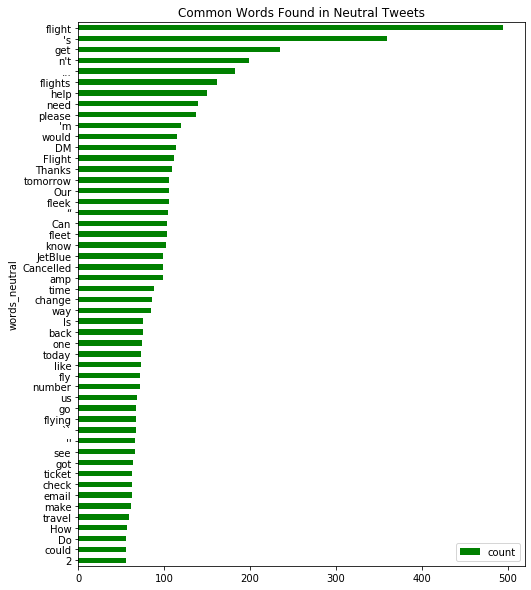

In [15]:
#For neutral words
fig, ax = plt.subplots(figsize=(8, 10))
freq_neutral.sort_values(by='count').plot.barh(x='words_neutral', y='count', ax=ax, color="green")
ax.set_title("Common Words Found in Neutral Tweets")
plt.show()

###__Explore the negative reasons__

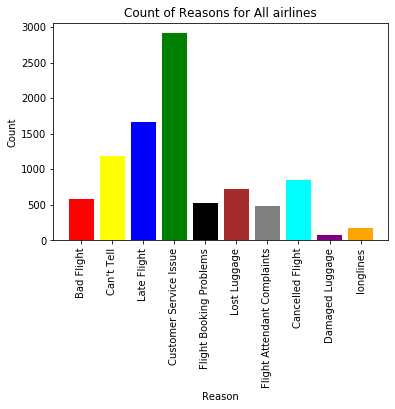

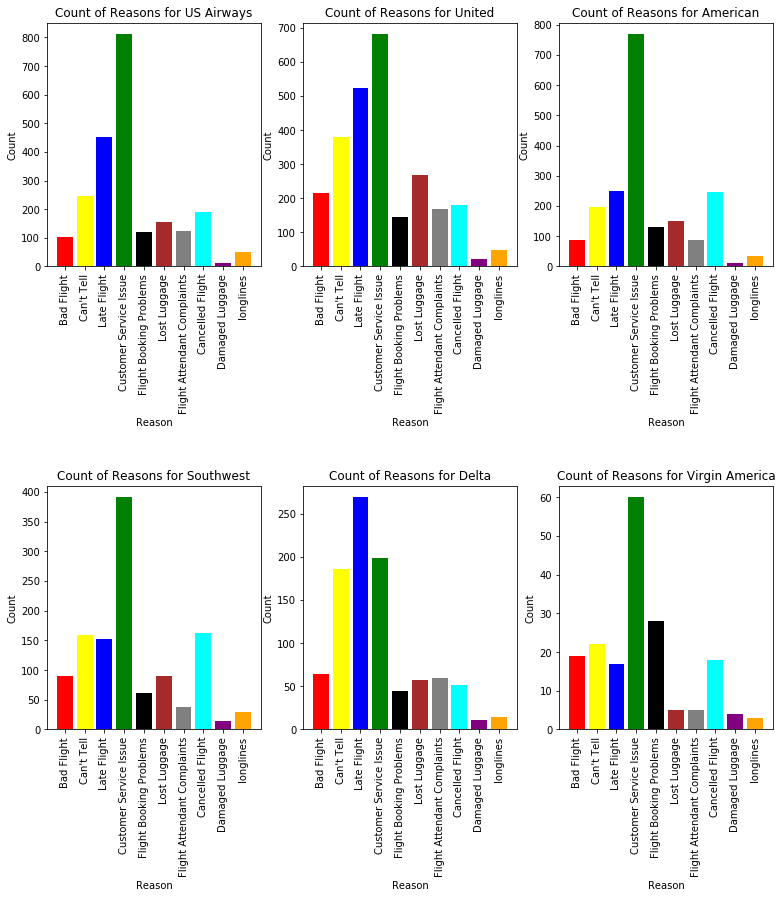

In [16]:
#Get the number of negative reasons
tweets['negativereason'].nunique()

NR_Count=dict(tweets['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All airlines':
        a=tweets
    else:
        a=tweets[tweets['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(tweets['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index, a['Reasons'], rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All airlines')
plt.figure(2, figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2, 3, indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

###__Explore if there are any relashionships between time and tweets__

In [17]:
date = tweets.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
tweets = date
day_df = tweets.groupby(['tweet_created','airline','airline_sentiment']).size()
day_df


tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

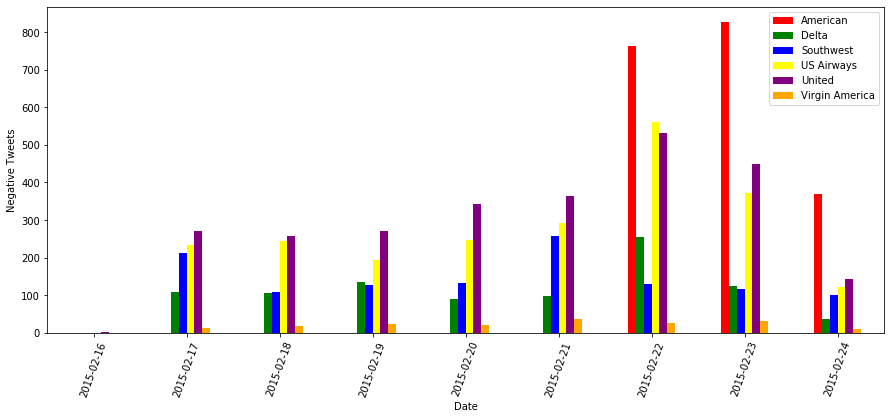

In [18]:
#Now we can plot it and see if we can get any interesting insights about negative tweets

day_df = day_df.loc(axis=0)[:, :, 'negative']

#Groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue', 'yellow', 'purple', 'orange'], figsize = (15, 6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

###__Data Cleaning for ULMFiT__
![image.png](https://humboldt-wi.github.io/blog/img/seminar/group4_ULMFiT/Figure_3.png)

Source: https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/

Since ULMFiT model is already trained on the WikiText-103 dataset, there is a list of all unique tokens in the dataset, ordered from most often to least often used as well as the same information formatted as a dictionary. Thus loading this vocabulary and dictionary enables us to encode our tweets text accordingly.

AWD-LSTM has to be rebuilt in order to be able to load in the weights of the trained model the ULMFiT's authors provided online. The preparation of the tweets dataset involves:
  * data cleaning (e.g. the removal of links),
  * splitting into train and test datasets,
  * tokenization (include adding meta-data tokens such as: indication of the beginning and the end of a sentence, capitalization and ALL CAPS spelling), and
  * encoding of all tweets.

Basically we need to focus on two main things:
* __Tokenization__, which meant splitting the raw texts into tokens (which can be words, or punctuation signs...). 

* __Numericalization__, which means that we are attributing a unique id to each token and mapping each of those tokens to their respective ids. 

## __Tokenization__

In [19]:
#Let's check the text of our tweets and decide what we can clean
tweets_preprocessed = tweets[['airline_sentiment','text']]
tweets_preprocessed.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [20]:
#Split dataset into train and test datasets
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#Split data into training and test set
train, test = train_test_split(tweets_preprocessed, test_size = 0.2, random_state = 678) #Explain why 678

# print lengths
print(len(train), len(test), sum([len(train), len(test)]))

11712 2928 14640


### Batchnig

In [21]:
#Language model data
data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = test, path = "")
data_lm.show_batch()

idx,text
0,/ xxunk xxbos @southwestair my bag was xxmaj late xxmaj flight - checked and put on a different flight from xxup xxunk . xxmaj having troubles tracking it down . xxmaj any help ? xxbos @united thank you for listening to my xxunk and doing the right thing . i appreciate you working with me xxbos @southwestair no self help way to put in tsa pre check number for existing
1,"xxunk ) on flight xxunk to xxmaj seattle has a tray table that is falling off ... http : / / t.co / xxunk xxbos @united xxmaj after an hour+ wait , my issue is resolved . i did contact customer service to comment on the wait time . xxmaj thanks for contacting me . xxbos @americanair xxmaj thank you , you too ! xxbos @jetblue as a customer it"
2,"23 agent this am who boarded flight xxunk to xxup dal . xxmaj did n't get his name . xxmaj he represents your brand so well . xxbos @usairways - xxmaj good to know that your phone customer service is still xxunk due to "" bad weather "" that was over a week ago # xxunk ? xxbos @southwestair i wish i would 've known so i could 've slept"
3,"of customer service . xxunk xxup est and no one can answer ? 2 / 2 xxbos @jetblue xxmaj finally taking off ! xxup las - xxup fll - xxup sju # letsgo xxbos @united xxmaj monday evening . xxbos @jetblue xxunk xxmaj love jetblue 's speedy xxmaj twitter customer service . xxbos @united xxmaj your staff , both on deck and in the cabin on xxup xxunk xxup sfo"
4,xxbos @united understanding the situation we waited and it was opened until 10:30pm xxbos 😕 xxup rt @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk xxbos @americanair xxmaj did n't really need anything . xxmaj saw your mentions are often negative . xxmaj keep up the good work . # xxunk 🇺 🇸 ✈ ️ xxbos @united hey awesome ! xxmaj thanks


As we can see, some words have been replaced by meta-tokens. All punctuation, hashtags and special characters are retained. The meta-tokens have the following meaning:

* __xxbos__: Begining of a sentence
* __xxfld__: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2)
* __xxup__: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
* __xxunk__: This token is used instead of an uncommon word.
* __xxmaj__: Token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
* __xxrep__: Token indicates a repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !)

In [22]:
data_lm.vocab.itos[:10] #list of unique tokens

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [23]:
#Classifier model data
data_clas = TextClasDataBunch.from_df(vocab=data_lm.train_ds.vocab, train_df = train, valid_df = test, bs=32, path = "")
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # freyasfund # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 🌏 🎀 http : / / t.co / xxunk,neutral
"xxbos @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative
xxbos @united - xxmaj kids left a kindle fire xxup hd 6 onboard xxup xxunk ( xxup ord - xxup sfo ) today . xxmaj row xxup xxunk - xxup def ( we had the whole row amongst the 5 of us ) . xxmaj help ...,neutral


###__Learning model__


When we create a learner, we have to pass in two things:
* The data: our language model data (data_lm)
* A pre-trained model: here, the pre-trained model is the Wikitext 103 model that will be downloaded from fastai.

In [24]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 5.25E-02


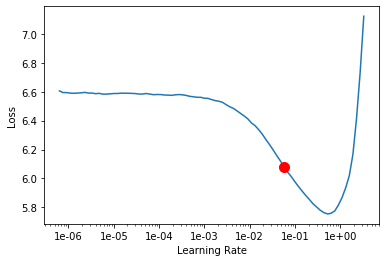

In [25]:
learn.lr_find() #Find the optimum learning rate to our dataset
learn.recorder.plot(suggestion=True)

We will take the learning rate with min loss and train our model

In [46]:
learn.fit_one_cycle(1, 5.25E-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.426088,0.511334,0.807036,03:39


In [48]:
#Now let's unfreeze the model
learn.unfreeze()
learn.fit_one_cycle(1, 5.25E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.443912,0.488951,0.816598,12:46


In [53]:
#Evaluate the language model
learn.predict('Thank flight was awful')

(Category positive, tensor(2), tensor([0.0119, 0.0035, 0.9846]))

In [0]:
#The above prediction doesn't look good, so let's keep training our model
#Save our encoder to use it later for classification
learn.save_encoder('ft_enc')

#### __Building a classifier__

In [55]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos @usairways why have me board a plane knowing there is a maint issue ? xxup us5235 .,xxbos @united is probably the least satisfactory airline i 've ever been on . xxmaj never fails to disappoint .,xxbos @virginamerica xxmaj beats xxup xxunk xxmaj views , xxmaj takes xxmaj on # southwestair xxup va xxup luv - xxmaj investor 's xxmaj business xxmaj daily http : / / t.co / xxunk,xxbos @southwestair my bag was xxmaj late xxmaj flight - checked and put on a different flight from xxup xxunk . xxmaj having troubles tracking it down . xxmaj any help ?,xxbos @united thank you for listening to my xxunk and doing the right thing . i appreciate you working with me
y: CategoryList
negative,negative,neutral,neutral,positive
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos @southwestair i 'm in line at the airport right now . xxmaj will you cover hotel fair or am i to sleep in the airport ?,xxbos @jetblue yes

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 3.63E-02


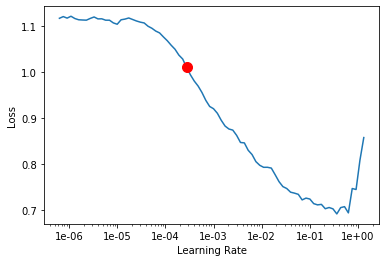

In [56]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [57]:
# train last layer
learn.fit_one_cycle(1, 3.63E-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.348756,0.535942,0.815915,03:37


In [58]:
# train last two layers
lr = 3.63E-02
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/2.5, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.355334,0.508766,0.811817,04:14


In [0]:
# train last three layers
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/2.5, lr))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
# train all layers
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(2, slice(lr/100, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.483686,0.454960,0.824112,10:12
1,0.321603,0.442249,0.830260,10:10


In [0]:
learn.predict('I love this airlines')

(Category positive, tensor(2), tensor([6.4165e-03, 2.8262e-05, 9.9356e-01]))

In [0]:
learn.predict('Horrible service, never again')

(Category negative, tensor(0), tensor([9.9565e-01, 3.6185e-03, 7.3117e-04]))

In [0]:
learn.predict('That was ok, nothing special')

(Category negative, tensor(0), tensor([0.6192, 0.1104, 0.2704]))